# 股票数据整理（6.7）

In [2]:
 # conda install rpy2

In [82]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import rpy2
import rpy2.robjects as robjects
from sklearn.utils import resample
import datetime
from datetime import datetime

dt1 = pd.read_csv('股票数据/行情序列2001年周数据.csv')
dt2 = pd.read_csv('股票数据/行情序列2002年周数据.csv')
dt3 = pd.read_csv('股票数据/行情序列2003年周数据.csv')
dt4 = pd.read_csv('股票数据/行情序列2004-5年周数据.csv')
dt5 = pd.read_csv('股票数据/行情序列2006-2009年周数据.csv')
dt6 = pd.read_csv('股票数据/行情序列2010-2013年周数据.csv')
dt7 = pd.read_csv('股票数据/行情序列2014-2018年周数据.csv')

dt = pd.concat([dt1,dt2,dt3,dt4,dt5,dt6,dt7], axis = 0, ignore_index = True)

dt_na = dt.dropna()

dt_na

dt.shape

dt_na.shape

dt_na.to_csv('数据已合并.csv', index = False, encoding='utf_8_sig')

# 数据初步描述分析（6.8）

见【data description script.R】文件

***描述性分析结果*** 
1. 一共截取328只基金的累积净值数据，运营时间最长的基金从周2005/1/7 - 周2018/12/28，包含715个数据点，有85%的基金单支拥有50 ~ 400个数据点, 其中有25.8%的基金单支拥有200~250个数据点。
2. 由04年至18年，每年数据点数量由最初的1个（仅2004/12/31, 上证500ETF一支）至15674个逐年增多。
3. 由04年至18年，基金数量由最初的1支至328支逐年增多，13年基金数量超过100支，14年后基金数量猛增。


# 数据在模型Kosowski、Fama&French的抽样试验（6.9 - 6.15）

In [4]:
# 基金数据导入
funds = pd.read_csv('funds_data.csv')

In [5]:
funds.shape

(68838, 4)

In [6]:
funds.head(5)

,代码,简称,时间,周单位净值(元)
0,510050.OF,50ETF,2004-12-31,0.996
1,510050.OF,50ETF,2005-01-07,0.981
2,510050.OF,50ETF,2005-01-14,0.983
3,510050.OF,50ETF,2005-01-21,0.988
4,510050.OF,50ETF,2005-01-28,0.976


In [7]:
funds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68838 entries, 0 to 68837
Data columns (total 4 columns):
代码          68838 non-null object
简称          68838 non-null object
时间          68838 non-null object
周单位净值(元)    68838 non-null float64
dtypes: float64(1), object(3)
memory usage: 2.1+ MB


In [8]:
# 基金回报率计算
funds['单位净值(初)']=funds.groupby('代码')['周单位净值(元)'].shift(1)
funds['净回报率'] = funds['周单位净值(元)']/funds['单位净值(初)'] - 1

In [9]:
funds.head(10)

,代码,简称,时间,周单位净值(元),单位净值(初),净回报率
0,510050.OF,50ETF,2004-12-31,0.996,NaN,NaN
1,510050.OF,50ETF,2005-01-07,0.981,0.996,-0.015060
2,510050.OF,50ETF,2005-01-14,0.983,0.981,0.002039
3,510050.OF,50ETF,2005-01-21,0.988,0.983,0.005086
4,510050.OF,50ETF,2005-01-28,0.976,0.988,-0.012146
5,510050.OF,50ETF,2005-02-04,0.873,0.976,-0.105533
6,510050.OF,50ETF,2005-02-18,0.856,0.873,-0.019473
7,510050.OF,50ETF,2005-02-25,0.878,0.856,0.025701
8,510050.OF,50ETF,2005-03-04,0.859,0.878,-0.021640
9,510050.OF,50ETF,2005-03-11,0.854,0.859,-0.005821


In [10]:
# Cahart模型因子数据导入
cahart = pd.read_csv('fivefactor_weekly.csv')

In [11]:
cahart.shape

(1372, 13)

In [12]:
cahart.head(5)

,trdwk,mkt_rf,smb,hml,umd,rf,smb_equal,hml_equal,umd_equal,rmw,cma,rmw_equal,cma_equal
0,1994-01-14,-0.049785,-0.010605,-0.001557,0.012826,0.002005,-0.006920,0.007555,0.010533,0.010301,-0.022515,0.001189,-0.019500
1,1994-01-21,-0.040166,0.024709,0.006786,0.034309,0.002005,0.018672,0.004249,0.023625,-0.023659,-0.015334,-0.023030,-0.000086
2,1994-01-28,-0.058775,0.023957,0.032066,-0.033173,0.002005,0.027413,0.025122,-0.024170,-0.031257,-0.035271,-0.024394,-0.017531
3,1994-02-04,0.063141,-0.030274,-0.053609,0.008469,0.002005,-0.037995,-0.052423,-0.003859,0.070407,0.031119,0.068059,0.005449
4,1994-02-18,-0.100108,0.034504,0.044310,0.002641,0.002005,0.033935,0.033539,0.008561,-0.074498,-0.036797,-0.051754,-0.007289


In [13]:
cahart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 13 columns):
trdwk        1372 non-null object
mkt_rf       1372 non-null float64
smb          1372 non-null float64
hml          1372 non-null float64
umd          1372 non-null float64
rf           1372 non-null float64
smb_equal    1372 non-null float64
hml_equal    1372 non-null float64
umd_equal    1372 non-null float64
rmw          1372 non-null float64
cma          1372 non-null float64
rmw_equal    1372 non-null float64
cma_equal    1372 non-null float64
dtypes: float64(12), object(1)
memory usage: 139.4+ KB


In [14]:
# 时间类数据格式调整
funds['时间'] = pd.to_datetime(funds['时间'], format='%Y-%m-%d')
cahart['trdwk'] = pd.to_datetime(cahart['trdwk'], format='%Y-%m-%d')

## Kosowaski模型（6.9 - 6.11）

### 1、构建残差population

按照Kosowaski模型，根据Cahart四因子模型构建各基金alpha, 周因子数据由国泰安数据库提供。

##### 对齐四因子与基金周收益时间点
取四因子及最长运营的基金周收益05/01/07 - 18/12/28数据进行right_join, 结果如下；

***观察结果***：周因子数据与单支基金周净值数据存在差值，周因子数据缺失2006/10/6、2007/10/5、2009/12/31、2013/12/31四周数据，为计算alpha、载荷及残差用缺失值上值进行填补。
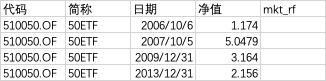

#### 合并四因子与基金收益率

In [15]:
# 取Cahart模型所需因子：市场风险因子（mkt_rf）、规模风险因子（smb）、账面市值比风险因子（hml）、惯性/动量因子（umd）及无风险利率（rf）
c1 = cahart[(cahart['trdwk']>="2005-01-07")&(cahart['trdwk']<="2018-12-28")]
c2 = c1[['trdwk','mkt_rf','smb','hml','umd','rf']]
# 取基金净值有效时间段内数据
f = funds[(funds['时间']>='2005-01-07')&(funds['时间']<='2018-12-28')]
f = f.rename(columns = {'时间': 'trdwk'})
# 合并因子与基金净值
cmodel = pd.merge(f, c2, how='left', on='trdwk')

In [16]:
# 处理缺失值： 用上一个非缺失值填补
cmodel = cmodel.fillna(method='ffill')

In [17]:
# 调整合并后数据列名
cmodel = cmodel.drop(columns = ['周单位净值(元)', '单位净值(初)'])
cmodel = cmodel.rename(columns = {'代码': 'code', '简称': 'name', '净回报率': 'ri'})

In [18]:
cmodel.shape

(68509, 9)

In [19]:
cmodel.head(5)

,code,name,trdwk,ri,mkt_rf,smb,hml,umd,rf
0,510050.OF,50ETF,2005-01-07,-0.015060,-0.009569,0.016692,-0.001600,-0.026043,0.000428
1,510050.OF,50ETF,2005-01-14,0.002039,0.002330,0.006033,0.002732,-0.003396,0.000428
2,510050.OF,50ETF,2005-01-21,0.005086,-0.008801,0.004323,0.002299,-0.018932,0.000428
3,510050.OF,50ETF,2005-01-28,-0.012146,-0.022081,-0.017804,-0.002866,0.034744,0.000428
4,510050.OF,50ETF,2005-02-04,-0.105533,0.027939,-0.046164,0.001879,0.039884,0.000428


In [20]:
# 查看净值与四因子之间相关性
corr_dt = cmodel[3:]

In [21]:
corr_dt.corr()

,ri,mkt_rf,smb,hml,umd,rf
ri,1.000000,0.304408,0.075035,-0.038966,-0.000128,0.020507
mkt_rf,0.304408,1.000000,0.393862,-0.195522,0.087409,0.056437
smb,0.075035,0.393862,1.000000,-0.525071,-0.106395,0.077798
hml,-0.038966,-0.195522,-0.525071,1.000000,-0.066269,-0.043882
umd,-0.000128,0.087409,-0.106395,-0.066269,1.000000,-0.011658
rf,0.020507,0.056437,0.077798,-0.043882,-0.011658,1.000000


#### 建立OLS回归模型

根据论文描述，Kosowaski模型是对单支基金先OLS回归得到残差，再对单支基金的残差pop进行bootstrap抽样，一次bootstrap抽样能得到一组残差样本，在计算出一组伪净值数据，根据一组伪净值数据用OLS回归计算出一个伪alpha。

bootstrap对单支基金抽样b次能得到b个伪alpha，抽样n个基金能构成一个n乘以b的alpha分布。

In [22]:
funds_list = cmodel.code.unique() # 基金清单

In [23]:
# 多基金残差计算
def res_caculator(f):
    Y = f['ri']-f['rf']
    result = sm.OLS(Y, sm.add_constant(f.loc[:, ['mkt_rf', 'smb', 'hml', 'umd']])).fit() # 净值根据Cahart四因子做线性回归
    y_dot = result.fittedvalues # 线性方程拟合后计算净值预测值
    res = Y - y_dot # 净值与净值预测值相减形成残差
    
    # 记录回归方程中各参数取值
    coef = {}
    coef.update(alpha_dot = result.params[0], mkt_b = result.params[1], smb_b = result.params[2], hml_b = result.params[3],  umd_b = result.params[4])
    
    # 返回res计算后的单支基金数据及对应的四因子回归方程系数
    return (res, coef) 

cmodel.groupby('code').apply(lambda x:)

In [24]:
########## TEST ###########
funds1 = cmodel[cmodel['code'] == funds_list[0]].reset_index(drop=True) # 使用基金清单中第一支基金测试以上残差计算函数
plt1 = res_caculator(funds1)[0]
coefs = res_caculator(funds1)[1]

/Users/xurui/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


/Users/xurui/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


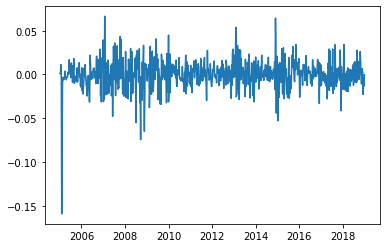

In [25]:
########## TEST ###########
fig = plt.figure()  # 残差计算结果，表现出四因子估计值与基金真是净值时序之间的关系 
ax = fig.add_subplot(111)
funds1.loc[:,'res'] = plt1
ax.plot(funds1.trdwk, funds1.res) # 残差分布在[-0.1, 0.1]之间

### 2. 构建基金回报率伪时间序列、伪Alpha计算方程 （6.15）

Kosowski模型创造基金回报率伪时间序列的方式是首先对残差数列进行有放回抽样，使用抽样残差数列，配合以下公式计算基金回报率伪时间序列：
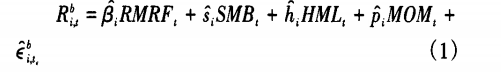

#### 残差抽样方程

In [26]:
# kosowski模型针对残差的Bootstrap抽样（******* 抽样部分之后要加入最优时序分块和家族分块步骤 ********）
def k_sampling(res):
    # 残余抽样
    n = len(res)
    spl_res = resample(res, n_samples = n, replace = 1)
    
    return spl_res

In [27]:
def k_sampling1(res):
    # 最优时序分块采样
    spl_res = robjects.r['tsbootstrap'](res, nb = 500, statistic = mean, m = 1)
    return spl_res

In [28]:
########## TEST ###########
plt1_k_sample = k_sampling(plt1)
plt1_k_sample.shape

(715,)

In [29]:
k_sampling1(plt1)

LookupError: 'tsbootstrap' not found

#### 伪Alpha计算方程
得到回报率伪时间序列后，再通过CahartOLS再次回归，得到该基金伪Alpha

In [30]:
# kosowski模型抽样残差进行伪回报及伪alpha计算
def k_fake_alpha_calculator(res, coef, cahart_factors):
    res = res.reset_index(drop=True)
    
    # 通过残差抽样计算伪回报率
    fake_y = cahart_factors['mkt_rf']*coef.get('mkt_b') + cahart_factors['smb']*coef.get('smb_b') + \
                   cahart_factors['hml']*coef.get('hml_b') + cahart_factors['umd']*coef.get('umd_b') + res
    
    # 得到伪回报率，通过伪回报率Cahart OLS回归得到基金伪Alpha.
    fake_result = sm.OLS(fake_y, sm.add_constant(cahart_factors.loc[:, 'mkt_rf':'umd'])).fit()
    fake_alpha = fake_result.params[0]
    fake_ta = fake_result.tvalues[0]
    
    return (fake_alpha, fake_ta)

In [31]:
########## TEST ###########
k_fake_alpha_calculator(plt1_k_sample, coefs, funds1)

(-0.0004968805778473432, -0.7280767467510005)

### 3. 计算运气Alpha分布 （6.15 - 6.17）

！**目前思路**
1. 计算所有基金真实alpha【alpha】及其alpha的t-test值【ta】，对真实alpha进行排序；
2. 计算一次所有基金伪alpha【fk_alpha】及其对应的t-test值，并对fk_alpha排序，记为Series1；
3. 重复1000次伪alpha序列计算，得到1000个Series.
4. 计算1000个Series每个rank(length：328)上的t-test平均数【mean_tfa】
5. 在每个rank上，计算【alpha】在1000个【fk_alpha】构成的【运气alpha分布】上小于其的百分比，记为【%<Act】

In [32]:
cmodel.head(10)

,code,name,trdwk,ri,mkt_rf,smb,hml,umd,rf
0,510050.OF,50ETF,2005-01-07,-0.015060,-0.009569,0.016692,-0.001600,-0.026043,0.000428
1,510050.OF,50ETF,2005-01-14,0.002039,0.002330,0.006033,0.002732,-0.003396,0.000428
2,510050.OF,50ETF,2005-01-21,0.005086,-0.008801,0.004323,0.002299,-0.018932,0.000428
3,510050.OF,50ETF,2005-01-28,-0.012146,-0.022081,-0.017804,-0.002866,0.034744,0.000428
4,510050.OF,50ETF,2005-02-04,-0.105533,0.027939,-0.046164,0.001879,0.039884,0.000428
5,510050.OF,50ETF,2005-02-18,-0.019473,-0.003800,0.015662,0.002797,-0.023485,0.000428
6,510050.OF,50ETF,2005-02-25,0.025701,0.048254,0.018829,-0.004707,-0.026505,0.000428
7,510050.OF,50ETF,2005-03-04,-0.021640,-0.019270,0.003282,0.001065,0.005858,0.000428
8,510050.OF,50ETF,2005-03-11,-0.005821,0.005934,0.001145,-0.007179,0.021298,0.000428
9,510050.OF,50ETF,2005-03-18,-0.038642,-0.053441,-0.012729,0.008282,0.034170,0.000428


In [33]:
# 第一步：计算所有基金真实Alpha并排序 #
alpha = []
ta = []

for fund in funds_list:
    tmp_f = cmodel[cmodel['code'] == fund].reset_index(drop=True)
    X = tmp_f.loc[:, 'mkt_rf':'umd']
    Y = tmp_f.ri - tmp_f.rf
    
    true_ols = sm.OLS(Y, sm.add_constant(X)).fit()
    alpha_i = true_ols.params[0]
    ta_i = true_ols.tvalues[0]
    
    alpha.append(alpha_i)
    ta.append(ta_i) 

/Users/xurui/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [34]:
# alpha及其t-value数列的排序及整理方程
def series_manipulator(alpha, ta):
    # 将两个List合并到一起，按alpha排序
    alpha = np.array(alpha).reshape(len(alpha),1)
    ta = np.array(ta).reshape(len(ta),1)

    one_fund_array = np.hstack([alpha, ta])
    one_fund_array = one_fund_array[np.argsort(one_fund_array[:,0]),:]
    
    # 将排好序的alpha和其t-value分开，变成两个二维数组
    one_fund_list = np.hsplit(one_fund_array,2)
    
    return one_fund_list

In [35]:
# 排序
true_alpha_series = series_manipulator(alpha, ta)

In [36]:
true_alpha_series[0][:5]

array([[-0.03364046],
       [-0.01393063],
       [-0.01209918],
       [-0.00752969],
       [-0.00392933]])

# ! **算力不足问题**
目前伪Alpha计算并排序的步骤循环5次大约需要1分钟，20次大约需要4分半，预计如需循环计算1000次需要3~4个小时

In [37]:
# 第三步：重复计算所有基金伪Alpha series并排序 #
myalphalist = []
mytalist = []

for b in range(20):
    fk_alpha = []
    fk_ta = [] 
    
    # 第二步：计算所有基金伪Alpha并排序，记为Series1 #
    for fund in funds_list:
        tmp_f = cmodel[cmodel['code'] == fund].reset_index(drop=True)
        tmp_cahart = tmp_f.loc[:, 'mkt_rf':'umd']   # 当前基金对应的Cahart四因子数据
        
        tmp_res = res_caculator(tmp_f) # 计算单支基金四因子回归模型的残余
        coef = tmp_res[1] # 当前基金Cahart OLS回归后各因子参数

        #  当前基金残余Bootstrap抽样
        bootstrap_res = k_sampling(tmp_res[0])
        
        #  计算单次抽样res产生的伪净值序列
        fk_data = k_fake_alpha_calculator(bootstrap_res, coef, tmp_cahart) 
        fk_alpha_i = fk_data[0]
        fk_ta_i = fk_data[1]
    
        fk_alpha.append(fk_alpha_i)
        fk_ta.append(fk_ta_i)
   
    one_fund_list = series_manipulator(fk_alpha, fk_ta)
    alpha_series_i = one_fund_list[0]
    ta_series_i = one_fund_list[1]
    
    myalphalist.append(alpha_series_i)
    mytalist.append(ta_series_i)

/Users/xurui/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [38]:
mat = np.array(myalphalist)
mat.shape

(20, 328, 1)

In [39]:
mat[19,:5,:5]

array([[-0.07254606],
       [-0.02169833],
       [-0.02007952],
       [-0.01849653],
       [-0.00713861]])

## Fama&French模型（6.18）

Fama&French模拟回报率伪时间序列的方式与Kosowsk模型略有不同，主要步骤如下；
1. 计算所有基金真实alpha的估计值 (之前已计算)
2. 使用F&F公式计算单支基金的伪回报率；
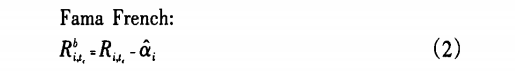
3. 对基金按月份分组，Bootstrap月数据，模拟伪回报率的时间序列，这种方法保留了周数据中基金组的截面数据
4. 对单支基金伪回报率的伪时间序列做Cahart OLS回归，得到单支基金伪alpha
5. 排序所有基金的伪alpha

In [55]:
# 第一步：计算真实Alpha的估计值
funds_list
alpha = np.array(alpha).reshape(328,)
ta = np.array(ta).reshape(328,)

In [67]:
df ={'code':funds_list, 'alpha':alpha, 'ta':ta }
df = pd.DataFrame(df)

In [70]:
fmodel = pd.merge(cmodel, df, on='code')
fmodel.head()

,code,name,trdwk,ri,mkt_rf,smb,hml,umd,rf,alpha,ta
0,510050.OF,50ETF,2005-01-07,-0.015060,-0.009569,0.016692,-0.001600,-0.026043,0.000428,0.000763,1.205157
1,510050.OF,50ETF,2005-01-14,0.002039,0.002330,0.006033,0.002732,-0.003396,0.000428,0.000763,1.205157
2,510050.OF,50ETF,2005-01-21,0.005086,-0.008801,0.004323,0.002299,-0.018932,0.000428,0.000763,1.205157
3,510050.OF,50ETF,2005-01-28,-0.012146,-0.022081,-0.017804,-0.002866,0.034744,0.000428,0.000763,1.205157
4,510050.OF,50ETF,2005-02-04,-0.105533,0.027939,-0.046164,0.001879,0.039884,0.000428,0.000763,1.205157


In [74]:
# 第二步：计算基金伪回报率
fmodel['fk_r'] = fmodel['ri'] - fmodel['alpha']

In [75]:
fmodel.head()

,code,name,trdwk,ri,mkt_rf,smb,hml,umd,rf,alpha,ta,fk_r
0,510050.OF,50ETF,2005-01-07,-0.015060,-0.009569,0.016692,-0.001600,-0.026043,0.000428,0.000763,1.205157,-0.015823
1,510050.OF,50ETF,2005-01-14,0.002039,0.002330,0.006033,0.002732,-0.003396,0.000428,0.000763,1.205157,0.001275
2,510050.OF,50ETF,2005-01-21,0.005086,-0.008801,0.004323,0.002299,-0.018932,0.000428,0.000763,1.205157,0.004323
3,510050.OF,50ETF,2005-01-28,-0.012146,-0.022081,-0.017804,-0.002866,0.034744,0.000428,0.000763,1.205157,-0.012909
4,510050.OF,50ETF,2005-02-04,-0.105533,0.027939,-0.046164,0.001879,0.039884,0.000428,0.000763,1.205157,-0.106296


In [83]:
time = fmodel["trdwk"]

# dt = datetime.strptime(dt, '%Y-%m-%d %H:%M:%S')
time = time.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

TypeError: strptime() argument 1 must be str, not Timestamp

In [ ]:
# train["pickup_month"] = dt.month
train["pickup_month"] = dt.map(lambda x: x.month)

train.head(1)